# Variational Autoencoder

VAEs are an improved autoencoder (with a modified encoder).

Instead of mapping an input to an exact point in the latent space, the encoder sample a point from a Gaussian distribution centered on a point in the latent space (mean) with a certain confidence (standard deviation). So the encoder has to predict the mean and the standard deviation that will be used to sample/represent the input in the latent space.

The result of this modification is that (by using a proper loss) the latent space will be centered and continuous (less gaps and more coherence for generating).

The Kullback-Leiber (KL) divergence helps to achieve this goal. This is a good way of measuring how much a probability distribution differs from another. For the variational autoencoder, it is important to know if the normal distribution is different from the distribution with the mean and standard deviation predicted by the encoder. The KL divergence penalizes the network for encoding inputs with a mean different than 0 (the encoding is not centered in the latent space) and with a log-var (logarithm of the variance) different than 0 (variance different than 1)(the encoder is not sure about where to place the input in the latent space).

For discrete probability distributions $P$ and $Q$ defined on the same sample space $X$:
$D_{KL}(P||Q) = \sum_{x \in X} P(x) \log \left( \frac{P(x)}{Q(x)} \right)$

In the case of the variational autoencoder:
$D_{KL}(N(\mu,\sigma)||N(0,1)) = \frac{1}{2} \sum \left( 1 + \log \left( \sigma^2\right) - \mu^2 - \sigma^2 \right)$

It is really easy to create an variational autoencoder using Keras Model Subclassing API as show in this [Tensorflow tutorial](https://www.tensorflow.org/tutorials/generative/cvae).

Let's build a variational autoencoder "from scratch" to have a better understanding!

## Hand Made Variational Autoencoder

In [1]:
import os
import numpy as np
import pandas as pd
import pickle

import tensorflow as tf
import keras.backend as K
from keras.models import Model
from keras.layers import Input, Conv2D, LeakyReLU, Flatten, Dense, Reshape, Conv2DTranspose, Activation, BatchNormalization, Dropout, Lambda
from keras.optimizers import Adam
from keras.losses import MeanSquaredError, KLDivergence
from keras.callbacks import Callback, LearningRateScheduler
from keras.callbacks import ModelCheckpoint
from keras.datasets import mnist
from keras.utils import plot_model

# Clear TensorFlow session
K.clear_session()

# Disable eaager execution
# from tensorflow.python.framework.ops import disable_eager_execution
# disable_eager_execution()

# Tensorflow debugging
# tf.debugging.enable_check_numerics()

import matplotlib.pyplot as plt

2023-11-25 22:05:17.262018: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-25 22:05:17.269390: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-25 22:05:17.346760: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-25 22:05:17.346814: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-25 22:05:17.348725: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

In [2]:
class CustomCallback(Callback):
    
    def __init__(self, run_folder, print_every_n_batches, initial_epoch, vae):
        self.epoch = initial_epoch
        self.run_folder = run_folder
        self.print_every_n_batches = print_every_n_batches
        self.vae = vae

    def on_batch_end(self, batch, logs={}):  
        if batch % self.print_every_n_batches == 0:
            z_new = np.random.normal(size = (1,self.vae.latent_dim))
            reconst = self.vae.decoder.predict(np.array(z_new))[0].squeeze()

            filepath = os.path.join(self.run_folder, 'images', 'img_' + str(self.epoch).zfill(3) + '_' + str(batch) + '.jpg')
            if len(reconst.shape) == 2:
                plt.imsave(filepath, reconst, cmap='gray_r')
            else:
                plt.imsave(filepath, reconst)

    def on_epoch_begin(self, epoch, logs={}):
        self.epoch += 1



def step_decay_schedule(initial_lr, decay_factor=0.5, step_size=1):
    '''
    Wrapper function to create a LearningRateScheduler with step decay schedule.
    '''
    def schedule(epoch):
        new_lr = initial_lr * (decay_factor ** np.floor(epoch/step_size))
        return new_lr

    return LearningRateScheduler(schedule)

### Encoder

In [3]:
class CustomLambdaLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(CustomLambdaLayer, self).__init__(**kwargs)

    def call(self, mu, log_var, **kwargs):
        epsilon = K.random_normal(shape=K.shape(mu), mean=0.0, stddev=1.0)
        return mu + K.exp(log_var / 2) * epsilon

In [4]:
class Encoder():

    def __init__(self, input_dim, encoder_n_layers, encoder_conv_filters, encoder_conv_kernel_sizes, encoder_conv_strides, latent_dim, batch_norm, dropout):
        self.input_dim = input_dim
        self.encoder_n_layers = encoder_n_layers
        self.encoder_conv_filters = encoder_conv_filters
        self.encoder_conv_kernel_sizes = encoder_conv_kernel_sizes
        self.encoder_conv_strides = encoder_conv_strides
        self.latent_dim = latent_dim
        self.batch_norm = batch_norm
        self.dropout = dropout

        self.input = Input(shape=self.input_dim, name="encoder_input")

        x = self.input

        for i in range(self.encoder_n_layers):
            conv_layer = Conv2D(filters=self.encoder_conv_filters[i],
                                kernel_size=self.encoder_conv_kernel_sizes[i],
                                strides=self.encoder_conv_strides[i],
                                padding="same",
                                name="encoder_conv_" + str(i))
            x = conv_layer(x)

            if self.batch_norm:
                x = BatchNormalization()(x)

            x = LeakyReLU(name="encoder_leaky_relu_" + str(i))(x)

            if self.dropout:
                x = Dropout(rate = 0.25)(x)

        # self.shape_before_flattening = tf.keras.backend.int_shape(x)[1:] # See decoder
        self.shape_before_flattening = x.shape[1:] # See decoder

        x = Flatten(name="encoder_flatten")(x)

        self.mu = Dense(self.latent_dim, name="mu")(x)
        self.log_var = Dense(self.latent_dim, name="log_var")(x)

        self.encoder_mu_log_var = Model(self.input, (self.mu, self.log_var))

        # def sampling(args):
        #     mu, log_var = args
        #     epsilon = K.random_normal(shape=K.shape(mu), mean=0.0, stddev=1.0)
        #     return mu + K.exp(log_var / 2) * epsilon

        # self.output = Lambda(sampling, name="output")([self.mu, self.log_var])
        self.output = CustomLambdaLayer(name="output")(self.mu, self.log_var)

        self.model = Model(self.input, self.output, name="encoder")

    def summary(self):
        self.model.summary()

    def predict(self, x):
        return self.model.predict(x)


### Decoder

In [5]:
class Decoder():

    def __init__(self, latent_dim, shape_before_flattening, decoder_n_layers, decoder_conv_t_filters, decoder_conv_t_kernel_sizes, decoder_conv_t_strides, output_dim, batch_norm, dropout):
        self.output_dim = output_dim
        self.shape_before_flattening = shape_before_flattening
        self.decoder_n_layers = decoder_n_layers
        self.decoder_conv_t_filters = decoder_conv_t_filters
        self.decoder_conv_t_kernel_sizes = decoder_conv_t_kernel_sizes
        self.decoder_conv_t_strides = decoder_conv_t_strides
        self.latent_dim = latent_dim
        self.batch_norm = batch_norm
        self.dropout = dropout

        self.input = Input(shape=(self.latent_dim,), name="decoder_input")

        x = Dense(np.prod(shape_before_flattening))(self.input) # Connect the input to a dense layer

        x = Reshape(self.shape_before_flattening)(x) # Reshape latent space vector for convolutional transpose layers

        for i in range(self.decoder_n_layers):
            conv_t_layer = Conv2DTranspose(filters=self.decoder_conv_t_filters[i],
                                           kernel_size=self.decoder_conv_t_kernel_sizes[i],
                                           strides=self.decoder_conv_t_strides[i],
                                           padding="same",
                                           name="decoder_conv_t_" + str(i))
            x = conv_t_layer(x)

            if i < self.decoder_n_layers - 1:
                x = LeakyReLU(name="decoder_leaky_relu_" + str(i))(x)
                
                if self.batch_norm:
                    x = BatchNormalization()(x)
                if self.dropout:
                    x = Dropout(rate = 0.25)(x)
            else:
                # x = Activation("sigmoid")(x)
                x = Activation(tf.keras.activations.sigmoid, name="decoder_sigmoid_" + str(i))(x)

        self.output = x

        self.model = Model(self.input, self.output, name="decoder")

    def summary(self):
        self.model.summary()

    def predict(self, x):
        return self.model.predict(x)
        

### Variational Autoencoder

In [6]:
# For more details about add_loss method: https://www.tensorflow.org/api_docs/python/tf/keras/layers/Layer#add_loss

class CustomKLDivergenceLayer(tf.keras.layers.Layer):

    def call(self, inputs):
        mu, log_var = inputs
        kl_loss = -0.5 * tf.reduce_sum(1 + log_var - tf.square(mu) - tf.exp(log_var), axis=1)
        self.add_loss(tf.reduce_mean(kl_loss))
        return inputs

In [7]:
class CustomLoss(tf.keras.losses.Loss):
    def __init__(self, r_loss_factor, encoder):
        super().__init__()
        self.r_loss_factor = r_loss_factor
        self.encoder = encoder
        self.mse = MeanSquaredError()
        self.kl_layer = CustomKLDivergenceLayer()

    def call(self, y_true, y_pred):
        r_loss = self.mse(y_true, y_pred)
        kl_inputs = [self.encoder.mu, self.encoder.log_var]
        self.kl_layer(kl_inputs)  # Call the KLDivergenceLayer to add KL divergence to the loss
        return self.r_loss_factor * r_loss

In [8]:
class VariationalAutoencoder():

    def __init__(self, input_dim,
                 encoder_n_layers, encoder_conv_filters, encoder_conv_kernel_sizes, encoder_conv_strides,
                 latent_dim,
                 decoder_n_layers, decoder_conv_t_filters, decoder_conv_t_kernel_sizes, decoder_conv_t_strides,
                 output_dim,
                 learning_rate, r_loss_factor, batch_norm, dropout):
        self.input_dim = input_dim
        self.encoder_n_layers = encoder_n_layers
        self.encoder_conv_filters = encoder_conv_filters
        self.encoder_conv_kernel_sizes = encoder_conv_kernel_sizes
        self.encoder_conv_strides = encoder_conv_strides
        self.latent_dim = latent_dim
        self.decoder_n_layers = decoder_n_layers
        self.decoder_conv_t_filters = decoder_conv_t_filters
        self.decoder_conv_t_kernel_sizes = decoder_conv_t_kernel_sizes
        self.decoder_conv_t_strides = decoder_conv_t_strides
        self.output_dim = output_dim
        self.learning_rate = learning_rate
        self.r_loss_factor = r_loss_factor
        self.batch_norm = batch_norm
        self.dropout = dropout

        # Create encoder
        self.encoder = Encoder(self.input_dim,
                               self.encoder_n_layers, self.encoder_conv_filters, self.encoder_conv_kernel_sizes, self.encoder_conv_strides,
                               self.latent_dim, self.batch_norm, self.dropout)
        
        # Create decoder
        self.decoder = Decoder(self.latent_dim, self.encoder.shape_before_flattening,
                               self.decoder_n_layers, self.decoder_conv_t_filters, self.decoder_conv_t_kernel_sizes, self.decoder_conv_t_strides,
                               self.output_dim, self.batch_norm, self.dropout)
        
        # Create model
        self.model_input = self.encoder.input
        self.model_output = self.decoder.model(self.encoder.output)

        self.model = Model(self.model_input, self.model_output, name="variational_autoencoder")

        # Compile model
        self.optimizer = Adam(learning_rate=self.learning_rate)

        # def vae_r_loss(y_true, y_pred):
        #     r_loss = K.mean(K.square(y_true - y_pred))
        #     return self.r_loss_factor * r_loss

        # def vae_kl_loss(y_true, y_pred):
        #     kl_loss = -0.5 * K.sum(1 + self.encoder.log_var - K.square(self.encoder.mu) - K.exp(self.encoder.log_var), axis=1)
        #     return kl_loss
        
        # def vae_loss(y_true, y_pred):
        #     r_loss = vae_r_loss(y_true, y_pred)
        #     kl_loss = vae_kl_loss(y_true, y_pred)
        #     loss = r_loss + kl_loss
        #     return loss

        # self.model.compile(optimizer=self.optimizer, loss=vae_loss, metrics=[vae_r_loss, vae_kl_loss])

        self.loss = CustomLoss(self.r_loss_factor, self.encoder)
        self.model.compile(optimizer=self.optimizer, loss=self.loss)

    def summary(self):
        self.model.summary()

    def plot_model(self, run_folder):
        plot_model(self.model, to_file=os.path.join(run_folder ,'viz/model.png'), show_shapes=True, show_layer_names=True)
        plot_model(self.encoder.model, to_file=os.path.join(run_folder ,'viz/encoder.png'), show_shapes=True, show_layer_names=True)
        plot_model(self.decoder.model, to_file=os.path.join(run_folder ,'viz/decoder.png'), show_shapes=True, show_layer_names=True)

    def load_weights(self, filepath="model/weights/params.pkl"):
        self.model.load_weights(filepath)

    def fit(self, x, y, batch_size, epochs, validation_split, shuffle, initial_epoch=0, print_every_n_batches=100, lr_decay=1):

        # Callbacks
        # custom_callback = CustomCallback("model", print_every_n_batches, initial_epoch, self)
        lr_sched = step_decay_schedule(initial_lr=self.learning_rate, decay_factor=lr_decay, step_size=1)
        # checkpoint2 = ModelCheckpoint(os.path.join("model", 'weights/weights.h5'), save_weights_only = True, verbose=1)

        callbacks_list = [lr_sched]

        # Training
        self.history = self.model.fit(x,
                                      y,
                                      batch_size=batch_size,
                                      epochs=epochs,
                                      callbacks=callbacks_list,
                                      validation_split=validation_split,
                                      shuffle=shuffle,
                                      initial_epoch=initial_epoch)
        return self.history

    def predict(self, x):
        return self.model.predict(x)

    def save(self, folder="model"):
        if not os.path.exists(folder):
            os.makedirs(folder)
            os.makedirs(os.path.join(folder, 'viz'))
            os.makedirs(os.path.join(folder, 'weights'))
            os.makedirs(os.path.join(folder, 'images'))

        with open(os.path.join(folder, 'weights/params.pkl'), 'wb') as f:
            pickle.dump([self.input_dim,
                         self.encoder_conv_filters,
                         self.encoder_conv_kernel_sizes,
                         self.encoder_conv_strides,
                         self.decoder_conv_t_filters,
                         self.decoder_conv_t_kernel_sizes,
                         self.decoder_conv_t_strides,
                         self.latent_dim,
                         self.batch_norm,
                         self.dropout], f)
        self.plot_model(folder)

In [9]:
LATENT_DIM = 2

variational_autoencoder = VariationalAutoencoder(input_dim=(28,28,1),
                                                  encoder_n_layers=4,
                                                  encoder_conv_filters=[32,64,64,64],
                                                  encoder_conv_kernel_sizes=[3,3,3,3],
                                                  encoder_conv_strides=[1,2,2,1],
                                                  latent_dim=LATENT_DIM,
                                                  decoder_n_layers=4,
                                                  decoder_conv_t_filters=[64,64,32,1],
                                                  decoder_conv_t_kernel_sizes=[3,3,3,3],
                                                  decoder_conv_t_strides=[1,2,2,1],
                                                  output_dim=(28,28,1),
                                                  learning_rate=10**-4,
                                                  r_loss_factor=10000,
                                                  batch_norm=True,
                                                  dropout=True)

In [10]:
# variational_autoencoder.plot_model("model")

In [11]:
variational_autoencoder.encoder.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_input (InputLayer)  [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 encoder_conv_0 (Conv2D)     (None, 28, 28, 32)           320       ['encoder_input[0][0]']       
                                                                                                  
 batch_normalization (Batch  (None, 28, 28, 32)           128       ['encoder_conv_0[0][0]']      
 Normalization)                                                                                   
                                                                                                  
 encoder_leaky_relu_0 (Leak  (None, 28, 28, 32)           0         ['batch_normalization[0]

In [12]:
variational_autoencoder.decoder.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 2)]               0         
                                                                 
 dense (Dense)               (None, 3136)              9408      
                                                                 
 reshape (Reshape)           (None, 7, 7, 64)          0         
                                                                 
 decoder_conv_t_0 (Conv2DTr  (None, 7, 7, 64)          36928     
 anspose)                                                        
                                                                 
 decoder_leaky_relu_0 (Leak  (None, 7, 7, 64)          0         
 yReLU)                                                          
                                                                 
 batch_normalization_4 (Bat  (None, 7, 7, 64)          256 

In [13]:
# variational_autoencoder.summary()

In [14]:
# DEBUG
# for layer in variational_autoencoder.model.layers:
#     print(layer.name, layer.output_shape)

### Load Data

In [15]:
# Load MNIST dataset
mnist_dataset = mnist.load_data()
(trainset, testset) = (mnist_dataset[0], mnist_dataset[1])
(X_train, y_train) = trainset
(X_test, y_test) = testset

# Preprocess data (convert to float and scale to between 0 and 1)
X_train = X_train.astype('float32')
X_train /= 255
X_test = X_test.astype('float32')
X_test /= 255

# Preprocess data (convert to uint8)
# y_train = y_train.astype('uint8')
# y_test = y_test.astype('uint8')

### Train

In [16]:
BATCH_SIZE = 32
# EPOCHS = 200
EPOCHS = 10

In [17]:
variational_autoencoder.fit(x=X_train,
                            y=X_train,
                            batch_size=BATCH_SIZE,
                            epochs=EPOCHS,
                            validation_split=0.1,
                            shuffle=True)

Epoch 1/10
1688/1688 [==============================] - 112s 64ms/step - loss: 910.0812 - val_loss: 646.8287 - lr: 1.0000e-04
Epoch 2/10
1688/1688 [==============================] - 97s 57ms/step - loss: 647.1740 - val_loss: 584.9980 - lr: 1.0000e-04
Epoch 3/10
1688/1688 [==============================] - 112s 67ms/step - loss: 603.6884 - val_loss: 555.5677 - lr: 1.0000e-04
Epoch 4/10
1688/1688 [==============================] - 125s 74ms/step - loss: 571.5209 - val_loss: 523.2366 - lr: 1.0000e-04
Epoch 5/10
1688/1688 [==============================] - 134s 79ms/step - loss: 548.7039 - val_loss: 504.6123 - lr: 1.0000e-04
Epoch 6/10
1688/1688 [==============================] - 129s 77ms/step - loss: 536.5122 - val_loss: 496.9316 - lr: 1.0000e-04
Epoch 7/10
1688/1688 [==============================] - 123s 73ms/step - loss: 527.9943 - val_loss: 492.3394 - lr: 1.0000e-04
Epoch 8/10
1688/1688 [==============================] - 120s 71ms/step - loss: 520.0453 - val_loss: 482.3498 - lr: 1.00

### Evaluate Variational Autoencoder

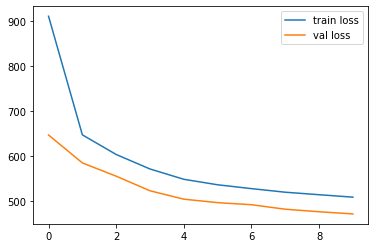

In [18]:
# Plot losses
losses = variational_autoencoder.history.history
plt.plot(losses["loss"], label="train loss")
plt.plot(losses["val_loss"], label="val loss")
plt.legend()
plt.show()

313/313 [==============================] - 8s 23ms/step


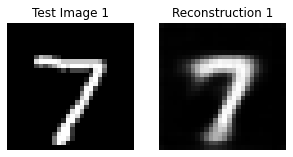

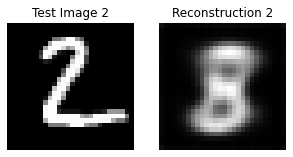

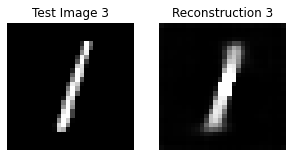

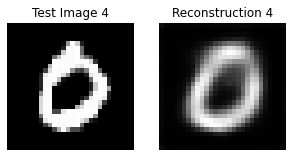

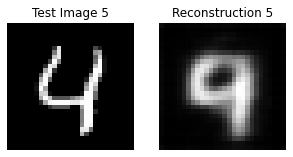

In [19]:
NB_PRED = 5
OFFSET = 0

predictions = variational_autoencoder.predict(X_test)

for i in range(NB_PRED):
    plt.figure(figsize=((5,5)))
    plt.subplot(1,2,1)
    plt.imshow(X_test[OFFSET + i], cmap="gray")
    plt.title("Test Image " + str(i+1))
    plt.axis("off")
    plt.subplot(1,2,2)
    plt.imshow(predictions[OFFSET + i], cmap="gray")
    plt.title("Reconstruction " + str(i+1))
    plt.axis("off")

### Save Model

In [20]:
variational_autoencoder.save()

### Load Pre-Trained Model

In [21]:
# variational_autoencoder.load_weights()

### Predictions

The distribution of the points in the latent space is unknown. For instance, with the mnist dataset and a latent space in 2D, it is possible top plot where each type of digit is located in the latent space.
- The plot is not symmetrical about the point (0,0): How should one choose a point in the latent space to produce a specific digit?
- Some digits are represented in the latent space over small areas and others over large areas: There will be a lack of diversity in the images produced. (More of the digits with the larger areas).
- There are large gaps between digits that contains few individuals: Some generated images (from the gaps) will be porrly formed
- The latent space is not continuous: Points in the middle of digits areas can also be ill-formed

In [22]:
NB_PRED = 5

latent_vector_init = np.random.random(size=(1,LATENT_DIM))

latent_vectors = tf.data.Dataset.from_tensor_slices([latent_vector_init + np.array([0, i]) for i in range(NB_PRED)])

list(latent_vectors.as_numpy_iterator())

[array([[0.69906749, 0.04193492]]),
 array([[0.69906749, 1.04193492]]),
 array([[0.69906749, 2.04193492]]),
 array([[0.69906749, 3.04193492]]),
 array([[0.69906749, 4.04193492]])]

In [23]:
latent_vectors

<_TensorSliceDataset element_spec=TensorSpec(shape=(1, 2), dtype=tf.float64, name=None)>

5/5 [==============================] - 0s 5ms/step


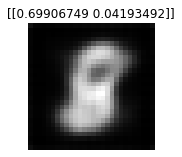

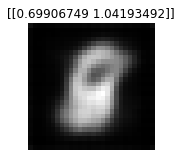

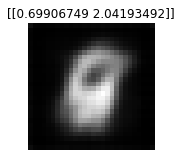

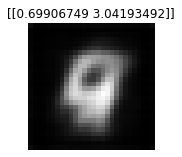

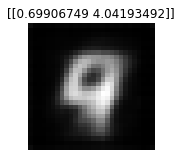

In [24]:
predictions = variational_autoencoder.decoder.predict(latent_vectors)

latent_vectors_iterator = iter(latent_vectors)
for i in range(NB_PRED):
    plt.figure(figsize=((5,5)))
    plt.subplot(1,2,1)
    plt.imshow(predictions[i], cmap="gray")
    plt.title(f"{latent_vectors_iterator.get_next()}")
    plt.axis("off")

In [25]:
import tensorflow_probability as tfp

def plot_latent_images(variational_autoencoder, n, digit_size=28):
  """Plots n x n digit images decoded from the latent space."""

  norm = tfp.distributions.Normal(0, 1)
  grid_x = norm.quantile(np.linspace(0.05, 0.95, n))
  grid_y = norm.quantile(np.linspace(0.05, 0.95, n))
  image_width = digit_size * n
  image_height = image_width
  image = np.zeros((image_height, image_width))

  for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
      z = np.array([[xi, yi]])
      x_decoded = variational_autoencoder.decoder.predict(z)
      digit = tf.reshape(x_decoded[0], (digit_size, digit_size))
      image[i * digit_size: (i + 1) * digit_size,
            j * digit_size: (j + 1) * digit_size] = digit.numpy()

  plt.figure(figsize=(10, 10))
  plt.imshow(image, cmap='Greys_r')
  plt.axis('Off')
  plt.show()

1/1 [==============================] - 0s 31ms/step


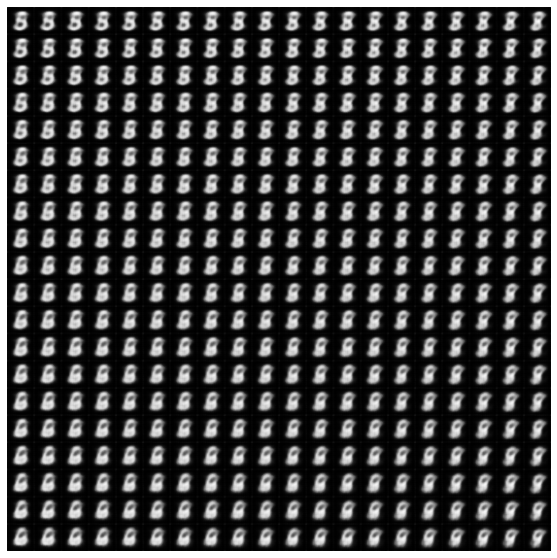

In [26]:
plot_latent_images(variational_autoencoder, 20, digit_size=28)

### Improvements

- Larger latent space, for instance use 200 dimensions to encode complex objects like faces
- Batch normalization after each convolution layer to speed up training
- Increase reconstruction loss factor (it requires tuning for every application but it could takes values like 10000)
- Use generator (**fit_generator**) to feed images to the variational autoencoder in order to avoid loading all the images in memory